- набор данных из 18 национальностей
- несбалансированное распределение фамилий в национальностях

# Импорты

In [80]:
# база
import pandas as pd
import warnings
import numpy as np
import json
from argparse import Namespace
import os
from tqdm import tqdm_notebook

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.lm import Vocabulary

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# метрика
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# константы
warnings.filterwarnings("ignore")
path = 'surnames_with_splits.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Куда ?: ', torch.cuda.is_available())

Куда ?:  True


In [2]:
data = pd.read_csv('surnames_with_splits.csv')
data.head()

,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [8]:
data['split'].value_counts()

split
train    7680
test     1660
val      1640
Name: count, dtype: int64

In [9]:
data['nationality'].value_counts()

nationality
English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: count, dtype: int64

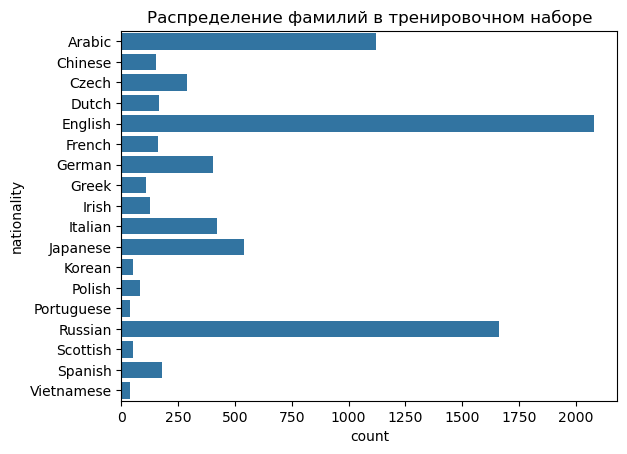

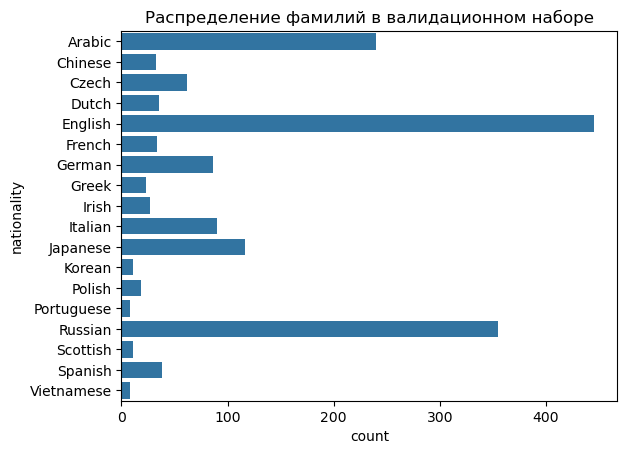

Text(0.5, 1.0, 'Распределение фамилий в тестовом наборе')

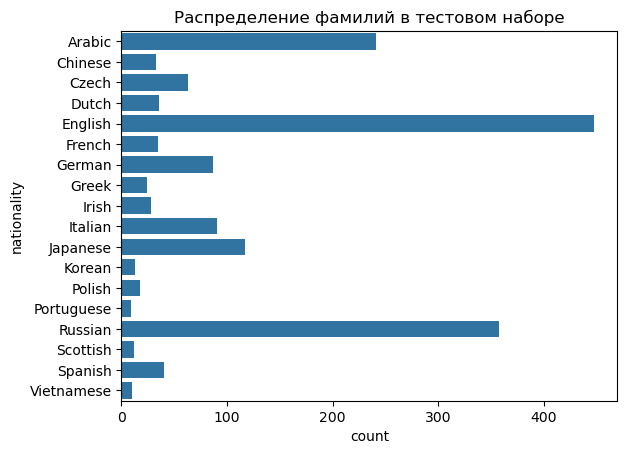

In [10]:
sns.countplot(data = data[data['split'] == 'train'],
              y = 'nationality')
plt.title('Распределение фамилий в тренировочном наборе')
plt.show()

sns.countplot(data = data[data['split'] == 'val'],
              y = 'nationality')
plt.title('Распределение фамилий в валидационном наборе')
plt.show()

sns.countplot(data = data[data['split'] == 'test'],
              y = 'nationality')
plt.title('Распределение фамилий в тестовом наборе')

# Кодировщик UNK

In [4]:
def частотное_кодирование_c_UNK_токеном(surname_vocab_token_i, surname):
    ''' 
    Буквенное One_hot кодирование фамилий

    Args:
        surname_vocab_token_i (dict): словарь токен-индекс (буква фамилии - индекс)
        surname (str): фамилия в строков типе
    Returns:
        one_hot вектор (кол-во UNK токенов на позиции -1)
    '''
    one_hot = np.zeros(len(surname_vocab_token_i), dtype = np.float32)
    for letter in surname:
        
        try:
            one_hot[surname_vocab_token_i[letter]] += 1
        except KeyError:
            one_hot[-1] += 1
            
    return one_hot


# Словари

In [5]:
def вернуть_словари(path,
                    unk_cutoff):
        surname_df = pd.read_csv(path)
        surname_df_train = surname_df[surname_df.split == 'train']
        # surname_vocab_i_token = {}
        surname_vocab_token_i = {}
        # nationality_vocab_i_token = {}
        nationality_vocab_token_i = {}
        # unk_token = '<UNK>'
        # surname_token_index = 0
        nationality_token_index = 0
        for index, row in surname_df_train.iterrows():
            # создание словаря национальностей
            # (присвоение числа по возрастающему индексу: 0,1,2,3...)
            # nationality_vocab_i_token[index] = row.nationality
            if row.nationality not in nationality_vocab_token_i.keys():
                nationality_vocab_token_i[row.nationality] = nationality_token_index
                nationality_token_index += 1

        # surname_vocab_i_token[surname_token_index] = unk_token
        # surname_vocab_token_i[unk_token] = surname_token_index
        letters_train_list = []
        for word in data.surname.values:
            for letter in word:
                letters_train_list.append(letter)

        vocab = Vocabulary(letters_train_list, unk_cutoff = unk_cutoff)
        surname_vocab_token_i = dict(zip(sorted(vocab), np.arange(0, len(vocab))))
        
        return surname_vocab_token_i,\
               nationality_vocab_token_i

# Dataset

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, file_path, mode, unk_cutoff):

        self.file_path = file_path
        self.mode = mode
        self.unk_cutoff = unk_cutoff

        # data loading
        self.surname_df = pd.read_csv(self.file_path).sample(frac = 1, random_state = 42)

        self.df_mode = self.surname_df[self.surname_df.split == self.mode]

        matrix_index = 0
        self.vocab_surname, self.vocab_nationality = вернуть_словари(self.file_path, self.unk_cutoff)
        self.x = np.zeros((len(self.df_mode), len(self.vocab_surname)), dtype = np.float32)
        self.y = np.zeros((len(self.df_mode), len(self.vocab_nationality)), dtype = np.float32)
        for index, row in self.df_mode.iterrows():
            one_hot_row = частотное_кодирование_c_UNK_токеном(surname_vocab_token_i = self.vocab_surname,
                                                            surname = row.surname)
            self.x[matrix_index] = one_hot_row

            ########
            one_hot_nation_row = np.zeros(len(self.vocab_nationality), dtype = np.float32)
            one_hot_nation_row[self.vocab_nationality[row.nationality]] = 1
            self.y[matrix_index] = one_hot_nation_row
            ########
            matrix_index += 1

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [9]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 64,
                              shuffle = True)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 64,
                             shuffle = False)

In [10]:
train_dataloader.dataset[:][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Тренировочный цикл

In [10]:
def training_loop(
        epoches,
        model,
        optimizer,
        loss_fn,
        train_dataloader,
        val_dataloader,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch
        ):
    
    loss_train_list = []
    loss_test_list = []
    
    ######### Выбор метрики #################
    # ROC_AUC_train_list = []
    # ROC_AUC_test_list = []
    # acc_train_list = []
    # acc_test_list = []
    # RMSE_train_list = []
    # RMSE_test_list = []
    f1_score_train = []
    f1_score_test = []
    ##########################################


    ##### Выбор тренировки модели (cpu / gpu)########
    # model = model.cpu()
    model = model.cuda()
    #################################################
    for epoch in range(1, epoches+1):

            loss_train = 0
            loss_test = 0
            all_outputs_train = torch.tensor([]).to(device)
            all_outputs_test = torch.tensor([]).to(device)
            # correct_train = 0
            # total_train = 0

            # correct_test = 0
            # total_test = 0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.cuda()
                labels = labels.cuda()
                # labels = labels.to(torch.long)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                all_outputs_train = torch.concat([all_outputs_train, outputs], dim = 0)
            
            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
                
            ######## Расчет метрики #####
            _, predict = torch.max(torch.softmax(all_outputs_train, dim = 1), dim = 1)
            y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
            f1_score_to_list_train = \
            f1_score(y_true = train_dataloader.dataset[:][1],
                    y_pred = y_pred.cpu().detach().numpy(),
                    average = 'micro')
            f1_score_train.append(f1_score_to_list_train)
            ##############################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.cuda()
                                        labels = labels.cuda()
                                        outputs = model(features)
                                        loss_on_test = loss_fn(outputs, labels)
                                        loss_test += loss_on_test.item()

                                        all_outputs_test = torch.concat([all_outputs_test, outputs], dim = 0)

                                mean_epoch_loss_test = loss_test / len(val_dataloader)
                                loss_test_list.append(mean_epoch_loss_test)

                                ######## Расчет метрики #####
                                _, predict = torch.max(torch.softmax(all_outputs_test, dim = 1), dim = 1)
                                y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
                                f1_score_to_list_test = \
                                f1_score(y_true = val_dataloader.dataset[:][1],
                                        y_pred = y_pred.cpu().detach().numpy(),
                                        average = 'micro')
                                f1_score_test.append(f1_score_to_list_test)
                                ##############################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                        
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {}/{}, train loss: {:.3f}, val_loss: {:.3f}, train f1_score: {:.3f}, val f1_score: {:.3f}'
                        .format(epoch,
                                epoches,
                                mean_epoch_loss,
                                mean_epoch_loss_test,
                                f1_score_to_list_train,
                                f1_score_to_list_test
                                )     
                      )
    
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_test_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                            optimizer.param_groups[0]['lr']))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_train,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_test,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('f1_score')
    plt.title('f1_score on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

    #
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_train_list,
    #             label = 'train')
    # plt.xlabel('эпохи')
    # plt.ylabel('accuracy')
    # plt.title('Точность от эпох: epoches: {}   lr: {}'.format(epoches,
    #                                                         optimizer.param_groups[0]['lr']))
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_test_list,
    #             label = 'test')
    # plt.legend()
    # plt.grid()
    # plt.show()
    
    return model

# Первая проба

Epoch 1/1000, train loss: 2.574, val_loss: 2.290, train f1_score: 0.257, val f1_score: 0.363
Epoch 100/1000, train loss: 1.378, val_loss: 1.429, train f1_score: 0.580, val f1_score: 0.563
Epoch 200/1000, train loss: 1.295, val_loss: 1.367, train f1_score: 0.600, val f1_score: 0.581
Epoch 300/1000, train loss: 1.256, val_loss: 1.341, train f1_score: 0.607, val f1_score: 0.587
Epoch 400/1000, train loss: 1.233, val_loss: 1.326, train f1_score: 0.612, val f1_score: 0.588
Epoch 500/1000, train loss: 1.217, val_loss: 1.316, train f1_score: 0.615, val f1_score: 0.592
Epoch 600/1000, train loss: 1.206, val_loss: 1.309, train f1_score: 0.615, val f1_score: 0.588
________________________Ранняя остановка_________________________________________________
На 650 эпохе пришлось остановить обучение
loss_550_эпохи - loss_650_эпохи < 0.01


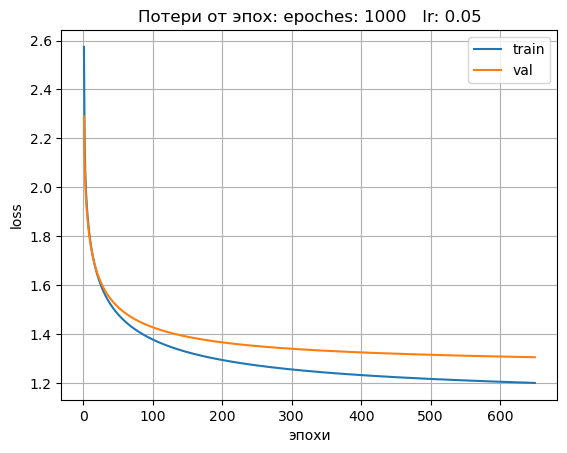

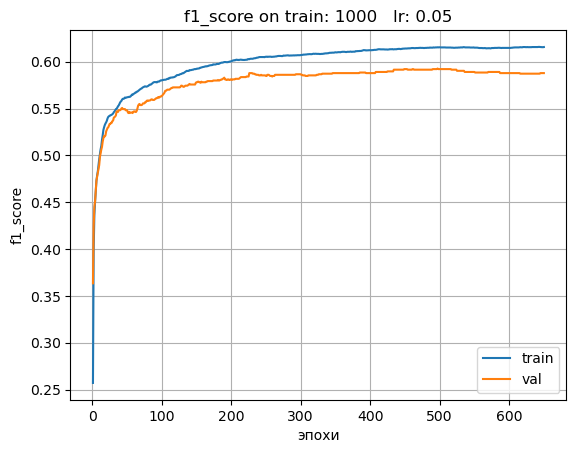

In [76]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.01,
    verbose_epoch = 100    
)

# Добавляем еще один скрытый слой (для возможного улучшении метрики)

Epoch 1/1000, train loss: 2.561, val_loss: 2.284, train f1_score: 0.274, val f1_score: 0.361
Epoch 100/1000, train loss: 1.041, val_loss: 1.163, train f1_score: 0.693, val f1_score: 0.645
Epoch 200/1000, train loss: 0.837, val_loss: 1.061, train f1_score: 0.740, val f1_score: 0.674
Epoch 300/1000, train loss: 0.719, val_loss: 1.038, train f1_score: 0.772, val f1_score: 0.680
Epoch 400/1000, train loss: 0.627, val_loss: 1.045, train f1_score: 0.802, val f1_score: 0.682
Epoch 500/1000, train loss: 0.552, val_loss: 1.071, train f1_score: 0.826, val f1_score: 0.673
Epoch 600/1000, train loss: 0.488, val_loss: 1.111, train f1_score: 0.850, val f1_score: 0.673
Epoch 700/1000, train loss: 0.434, val_loss: 1.162, train f1_score: 0.867, val f1_score: 0.668
Epoch 800/1000, train loss: 0.389, val_loss: 1.214, train f1_score: 0.881, val f1_score: 0.660
Epoch 900/1000, train loss: 0.350, val_loss: 1.268, train f1_score: 0.896, val f1_score: 0.659
Epoch 1000/1000, train loss: 0.316, val_loss: 1.330,

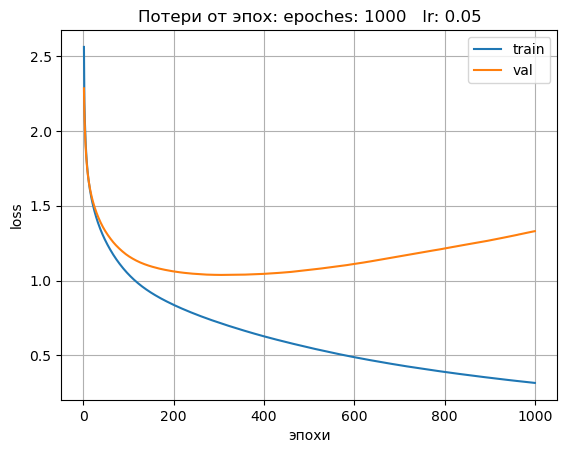

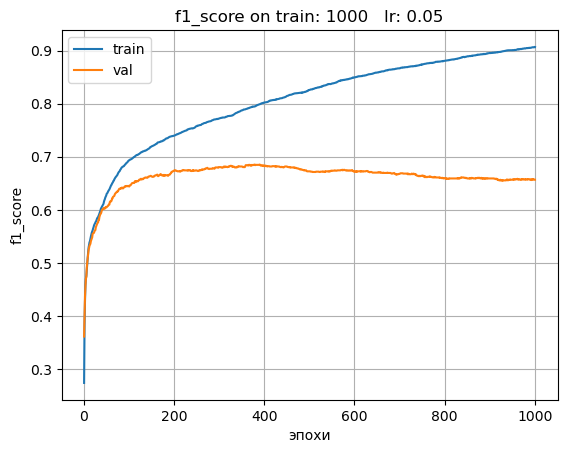

In [77]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),

                nn.Linear(in_features = num_features*2, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.01,
    verbose_epoch = 100    
)

# Переобучение ---> пробуем Dropout

Epoch 1/1000, train loss: 2.511, val_loss: 2.249, train f1_score: 0.284, val f1_score: 0.326
Epoch 100/1000, train loss: 1.180, val_loss: 1.200, train f1_score: 0.652, val f1_score: 0.634
Epoch 200/1000, train loss: 1.022, val_loss: 1.089, train f1_score: 0.685, val f1_score: 0.658
Epoch 300/1000, train loss: 0.946, val_loss: 1.040, train f1_score: 0.704, val f1_score: 0.669
Epoch 400/1000, train loss: 0.887, val_loss: 1.016, train f1_score: 0.717, val f1_score: 0.680
Epoch 500/1000, train loss: 0.846, val_loss: 1.001, train f1_score: 0.729, val f1_score: 0.687
Epoch 600/1000, train loss: 0.814, val_loss: 0.992, train f1_score: 0.741, val f1_score: 0.693
Epoch 700/1000, train loss: 0.795, val_loss: 0.989, train f1_score: 0.744, val f1_score: 0.695
Epoch 800/1000, train loss: 0.769, val_loss: 0.983, train f1_score: 0.748, val f1_score: 0.696
________________________Ранняя остановка_________________________________________________
На 851 эпохе пришлось остановить обучение
loss_851_эпохи 

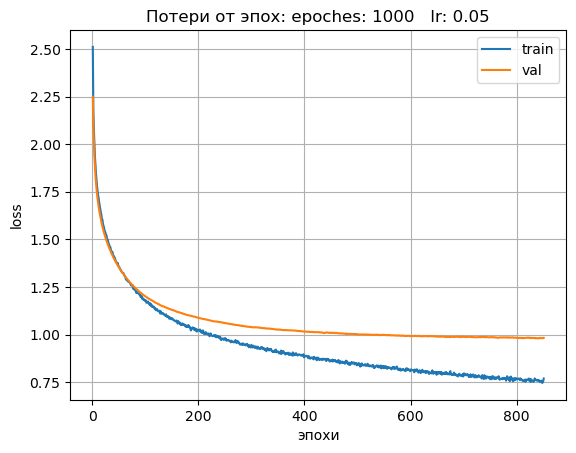

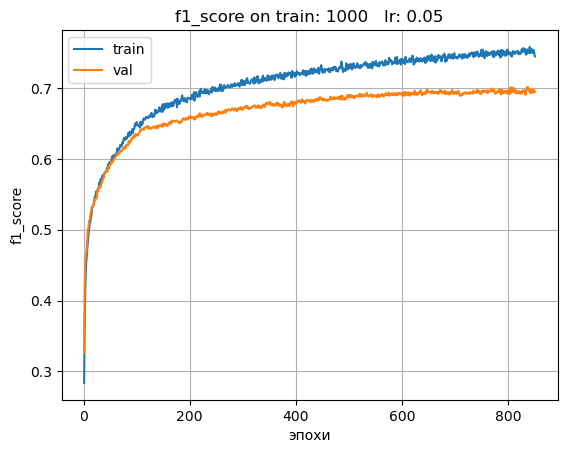

In [79]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

Epoch 1/1000, train loss: 2.537, val_loss: 2.264, train f1_score: 0.260, val f1_score: 0.272
Epoch 100/1000, train loss: 1.119, val_loss: 1.124, train f1_score: 0.659, val f1_score: 0.659
Epoch 200/1000, train loss: 0.946, val_loss: 1.018, train f1_score: 0.705, val f1_score: 0.683
Epoch 300/1000, train loss: 0.861, val_loss: 0.987, train f1_score: 0.719, val f1_score: 0.688
Epoch 400/1000, train loss: 0.789, val_loss: 0.980, train f1_score: 0.746, val f1_score: 0.695
Epoch 500/1000, train loss: 0.766, val_loss: 0.976, train f1_score: 0.748, val f1_score: 0.698
Epoch 600/1000, train loss: 0.720, val_loss: 0.978, train f1_score: 0.767, val f1_score: 0.693
Epoch 700/1000, train loss: 0.681, val_loss: 0.979, train f1_score: 0.774, val f1_score: 0.699
Epoch 800/1000, train loss: 0.665, val_loss: 0.990, train f1_score: 0.778, val f1_score: 0.701
________________________Ранняя остановка_________________________________________________
На 883 эпохе пришлось остановить обучение
loss_883_эпохи 

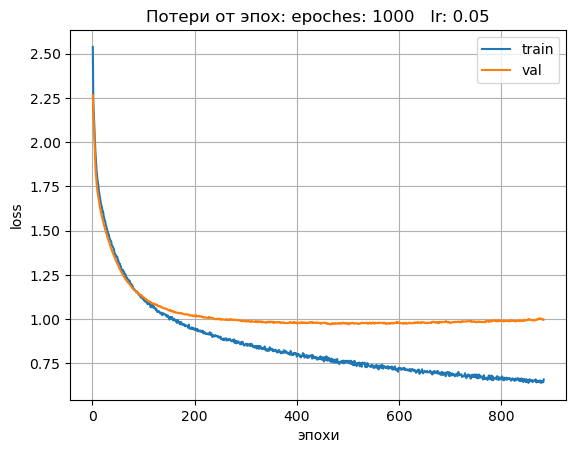

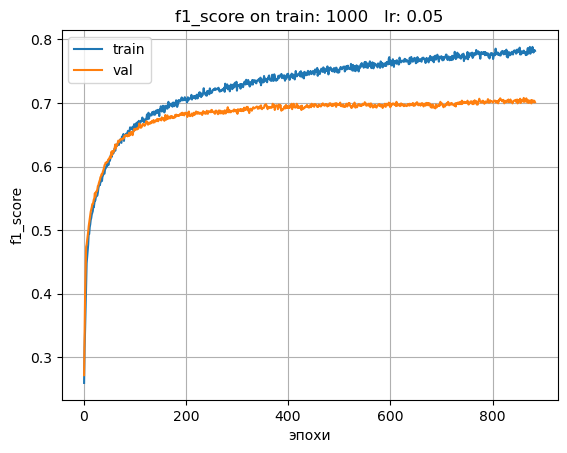

In [14]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

Epoch 1/1000, train loss: 2.434, val_loss: 2.190, train f1_score: 0.266, val f1_score: 0.285
Epoch 100/1000, train loss: 0.963, val_loss: 1.025, train f1_score: 0.703, val f1_score: 0.682
Epoch 200/1000, train loss: 0.815, val_loss: 0.987, train f1_score: 0.741, val f1_score: 0.694
Epoch 300/1000, train loss: 0.729, val_loss: 0.982, train f1_score: 0.758, val f1_score: 0.706
Epoch 400/1000, train loss: 0.674, val_loss: 0.990, train f1_score: 0.774, val f1_score: 0.706
Epoch 500/1000, train loss: 0.635, val_loss: 1.021, train f1_score: 0.783, val f1_score: 0.708
Epoch 600/1000, train loss: 0.594, val_loss: 1.032, train f1_score: 0.793, val f1_score: 0.700
Epoch 700/1000, train loss: 0.558, val_loss: 1.050, train f1_score: 0.809, val f1_score: 0.704
________________________Ранняя остановка_________________________________________________
На 787 эпохе пришлось остановить обучение
loss_787_эпохи >= loss_687_эпохи


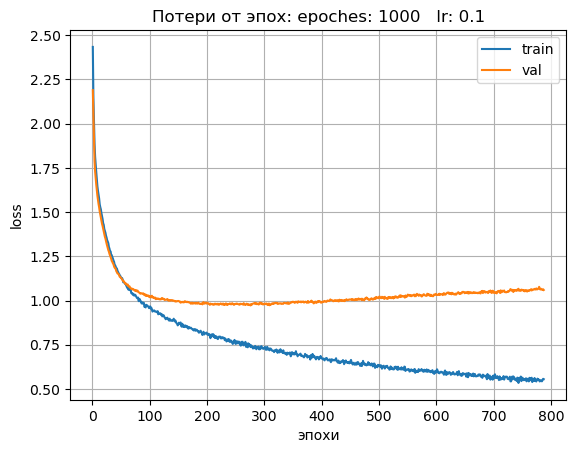

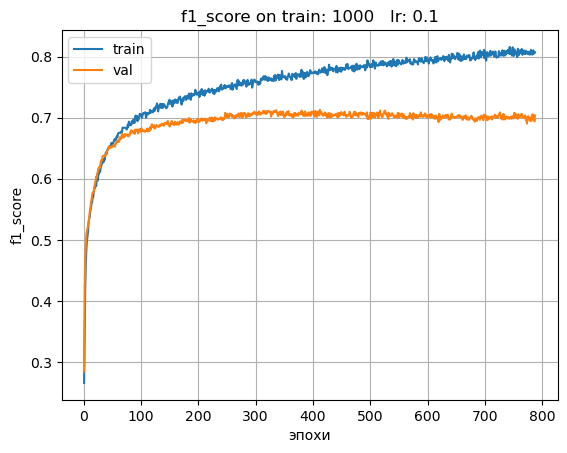

In [15]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

Epoch 1/1000, train loss: 2.813, val_loss: 2.750, train f1_score: 0.225, val f1_score: 0.271
Epoch 100/1000, train loss: 1.600, val_loss: 1.564, train f1_score: 0.540, val f1_score: 0.544
Epoch 200/1000, train loss: 1.399, val_loss: 1.371, train f1_score: 0.595, val f1_score: 0.595
Epoch 300/1000, train loss: 1.266, val_loss: 1.243, train f1_score: 0.625, val f1_score: 0.628
Epoch 400/1000, train loss: 1.173, val_loss: 1.166, train f1_score: 0.646, val f1_score: 0.645
Epoch 500/1000, train loss: 1.106, val_loss: 1.118, train f1_score: 0.669, val f1_score: 0.655
Epoch 600/1000, train loss: 1.048, val_loss: 1.084, train f1_score: 0.683, val f1_score: 0.668
Epoch 700/1000, train loss: 1.013, val_loss: 1.059, train f1_score: 0.687, val f1_score: 0.676
Epoch 800/1000, train loss: 0.984, val_loss: 1.043, train f1_score: 0.698, val f1_score: 0.676
Epoch 900/1000, train loss: 0.965, val_loss: 1.031, train f1_score: 0.704, val f1_score: 0.679
________________________Ранняя остановка____________

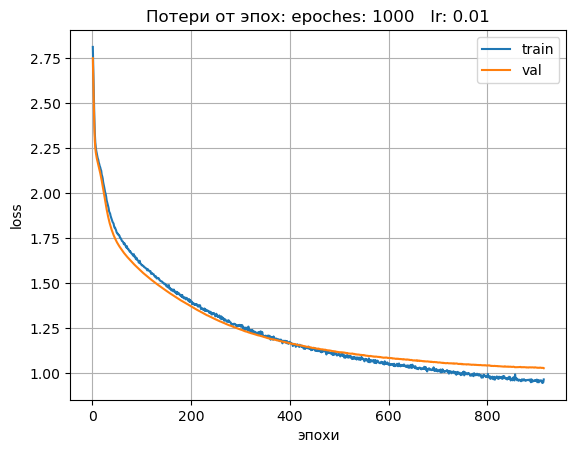

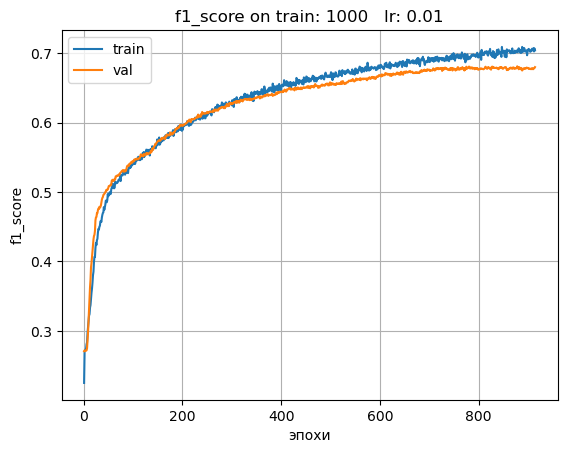

In [17]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

Epoch 1/2000, train loss: 2.575, val_loss: 2.300, train f1_score: 0.264, val f1_score: 0.271
Epoch 100/2000, train loss: 1.111, val_loss: 1.105, train f1_score: 0.665, val f1_score: 0.652
Epoch 200/2000, train loss: 0.940, val_loss: 1.013, train f1_score: 0.709, val f1_score: 0.680
Epoch 300/2000, train loss: 0.853, val_loss: 0.985, train f1_score: 0.729, val f1_score: 0.693
Epoch 400/2000, train loss: 0.794, val_loss: 0.971, train f1_score: 0.745, val f1_score: 0.697
Epoch 500/2000, train loss: 0.750, val_loss: 0.966, train f1_score: 0.759, val f1_score: 0.702
Epoch 600/2000, train loss: 0.716, val_loss: 0.964, train f1_score: 0.766, val f1_score: 0.705
Epoch 700/2000, train loss: 0.677, val_loss: 0.969, train f1_score: 0.776, val f1_score: 0.706
Epoch 800/2000, train loss: 0.660, val_loss: 0.972, train f1_score: 0.785, val f1_score: 0.711
________________________Ранняя остановка_________________________________________________
На 856 эпохе пришлось остановить обучение
loss_856_эпохи 

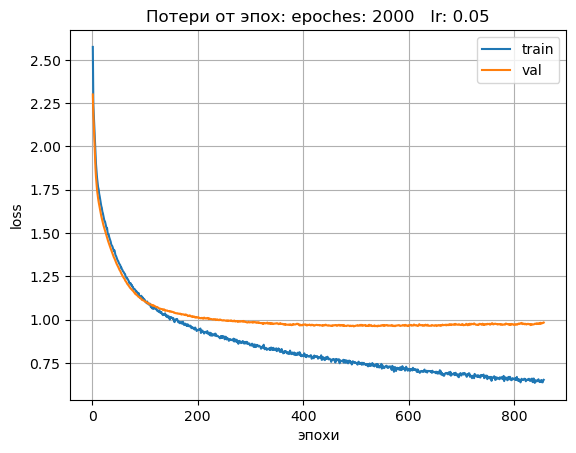

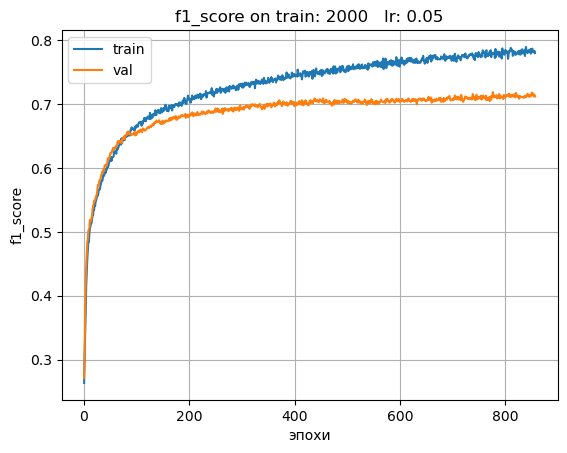

In [19]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

Epoch 1/1000, train loss: 2.619, val_loss: 2.342, train f1_score: 0.259, val f1_score: 0.271
Epoch 100/1000, train loss: 1.101, val_loss: 1.122, train f1_score: 0.671, val f1_score: 0.665
Epoch 200/1000, train loss: 0.913, val_loss: 1.040, train f1_score: 0.713, val f1_score: 0.685
Epoch 300/1000, train loss: 0.843, val_loss: 1.017, train f1_score: 0.732, val f1_score: 0.689
Epoch 400/1000, train loss: 0.766, val_loss: 1.022, train f1_score: 0.753, val f1_score: 0.690
Epoch 500/1000, train loss: 0.720, val_loss: 1.021, train f1_score: 0.767, val f1_score: 0.696
Epoch 600/1000, train loss: 0.690, val_loss: 1.025, train f1_score: 0.773, val f1_score: 0.701
Epoch 700/1000, train loss: 0.661, val_loss: 1.043, train f1_score: 0.779, val f1_score: 0.694
Epoch 800/1000, train loss: 0.640, val_loss: 1.056, train f1_score: 0.790, val f1_score: 0.695
________________________Ранняя остановка_________________________________________________
На 853 эпохе пришлось остановить обучение
loss_853_эпохи 

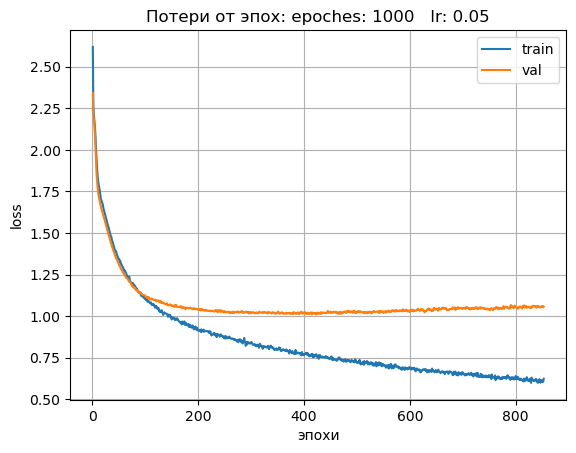

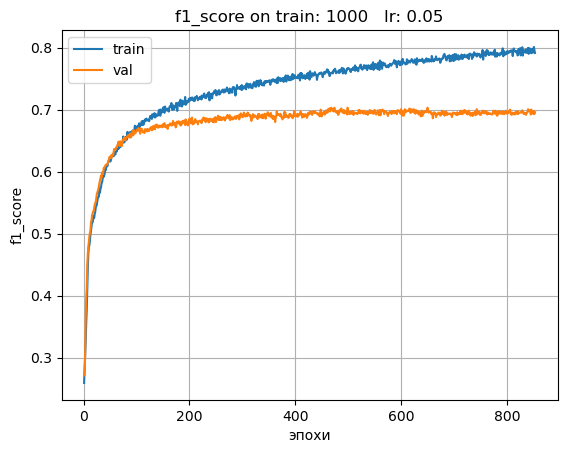

In [11]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*6),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*6, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100    
)

# Добавим регуляризацию в цикл обучения

In [6]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

In [7]:
def training_loop(
        epoches,
        model,
        optimizer,
        loss_fn,
        train_dataloader,
        val_dataloader,

        # regular
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        stop_diff_value,

        # verbose
        verbose_epoch

        ):
    
    loss_train_list = []
    loss_test_list = []
    
    ######### Выбор метрики #################
    # ROC_AUC_train_list = []
    # ROC_AUC_test_list = []
    # acc_train_list = []
    # acc_test_list = []
    # RMSE_train_list = []
    # RMSE_test_list = []
    f1_score_train = []
    f1_score_test = []
    ##########################################


    ##### Выбор тренировки модели (cpu / gpu)########
    # model = model.cpu()
    model = model.cuda()
    #################################################
    for epoch in range(1, epoches+1):

            loss_train = 0
            loss_test = 0
            all_outputs_train = torch.tensor([]).to(device)
            all_outputs_test = torch.tensor([]).to(device)
            # correct_train = 0
            # total_train = 0

            # correct_test = 0
            # total_test = 0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.cuda()
                labels = labels.cuda()
                # labels = labels.to(torch.long)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                loss = loss_with_l1_or_l2_regulizer(model = model,
                                                    type = reg_type,
                                                    l_lambda = 0.001,
                                                    loss_by_fn = loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()
                all_outputs_train = torch.concat([all_outputs_train, outputs], dim = 0)
            
            mean_epoch_loss = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss)
                
            ######## Расчет метрики #####
            _, predict = torch.max(torch.softmax(all_outputs_train, dim = 1), dim = 1)
            y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
            f1_score_to_list_train = \
            f1_score(y_true = train_dataloader.dataset[:][1],
                    y_pred = y_pred.cpu().detach().numpy(),
                    average = 'micro')
            f1_score_train.append(f1_score_to_list_train)
            ##############################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                                for features, labels in val_dataloader:
                                        features = features.cuda()
                                        labels = labels.cuda()
                                        outputs = model(features)
                                        loss_on_test = loss_fn(outputs, labels)
                                        loss_test += loss_on_test.item()
                                        
                                        all_outputs_test = torch.concat([all_outputs_test, outputs], dim = 0)

                                mean_epoch_loss_test = loss_test / len(val_dataloader)
                                loss_test_list.append(mean_epoch_loss_test)

                                ######## Расчет метрики #####
                                _, predict = torch.max(torch.softmax(all_outputs_test, dim = 1), dim = 1)
                                y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
                                f1_score_to_list_test = \
                                f1_score(y_true = val_dataloader.dataset[:][1],
                                        y_pred = y_pred.cpu().detach().numpy(),
                                        average = 'micro')
                                f1_score_test.append(f1_score_to_list_test)
                                ##############################
            if stop_mode:
                if len(loss_train_list) >= each__X__epoch:
                        past = loss_train_list[-each__X__epoch]
                        now = loss_train_list[-1]
                        if (past <= now):
                                print('________________________Ранняя остановка_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи >= loss_{}_эпохи'.format(epoch,
                                                                              epoch - each__X__epoch))
                                break
                        if (past - now) < stop_diff_value:
                                print('________________________Ранняя остановка_________________________________________________')
                                print('На {} эпохе пришлось остановить обучение'.format(epoch))
                                print('loss_{}_эпохи - loss_{}_эпохи < {}'.format(epoch - each__X__epoch,
                                                                                  epoch,
                                                                                  stop_diff_value))
                                break
                        
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {}/{}, train loss: {:.3f}, val_loss: {:.3f}, train f1_score: {:.3f}, val f1_score: {:.3f}'
                        .format(epoch,
                                epoches,
                                mean_epoch_loss,
                                mean_epoch_loss_test,
                                f1_score_to_list_train,
                                f1_score_to_list_test
                                )     
                      )
    
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_test_list,
                 label = 'val')
    plt.title('Потери от эпох: epoches: {}   lr: {}'.format(epoches,
                                                            optimizer.param_groups[0]['lr']))
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_train,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = f1_score_test,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('f1_score')
    plt.title('f1_score on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

    #
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_train_list,
    #             label = 'train')
    # plt.xlabel('эпохи')
    # plt.ylabel('accuracy')
    # plt.title('Точность от эпох: epoches: {}   lr: {}'.format(epoches,
    #                                                         optimizer.param_groups[0]['lr']))
    # sns.lineplot(x = range(1, epoches+1),
    #             y = accuracy_test_list,
    #             label = 'test')
    # plt.legend()
    # plt.grid()
    # plt.show()
    
    return model

Epoch 1/1000, train loss: 2.896, val_loss: 2.321, train f1_score: 0.250, val f1_score: 0.271
Epoch 100/1000, train loss: 1.410, val_loss: 1.200, train f1_score: 0.655, val f1_score: 0.648
Epoch 200/1000, train loss: 1.256, val_loss: 1.087, train f1_score: 0.690, val f1_score: 0.677
Epoch 300/1000, train loss: 1.204, val_loss: 1.053, train f1_score: 0.710, val f1_score: 0.685
Epoch 400/1000, train loss: 1.177, val_loss: 1.031, train f1_score: 0.714, val f1_score: 0.687
________________________Ранняя остановка_________________________________________________
На 461 эпохе пришлось остановить обучение
loss_461_эпохи >= loss_361_эпохи


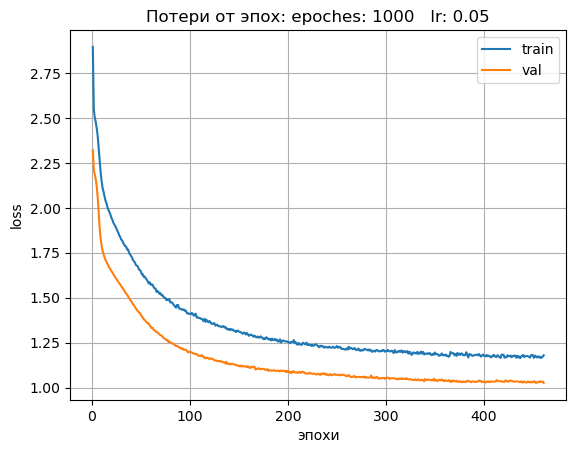

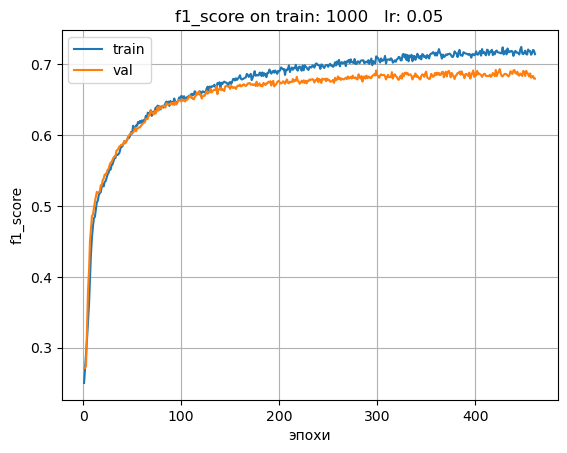

In [15]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*6),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*6, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 1000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 100,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 3.124, val_loss: 2.779, train f1_score: 0.225, val f1_score: 0.271
Epoch 100/2000, train loss: 1.933, val_loss: 1.638, train f1_score: 0.528, val f1_score: 0.534
Epoch 200/2000, train loss: 1.697, val_loss: 1.449, train f1_score: 0.590, val f1_score: 0.595
Epoch 300/2000, train loss: 1.545, val_loss: 1.321, train f1_score: 0.627, val f1_score: 0.618
Epoch 400/2000, train loss: 1.454, val_loss: 1.250, train f1_score: 0.644, val f1_score: 0.637
Epoch 500/2000, train loss: 1.395, val_loss: 1.196, train f1_score: 0.652, val f1_score: 0.645
Epoch 600/2000, train loss: 1.337, val_loss: 1.154, train f1_score: 0.668, val f1_score: 0.658
Epoch 700/2000, train loss: 1.304, val_loss: 1.124, train f1_score: 0.677, val f1_score: 0.664
Epoch 800/2000, train loss: 1.264, val_loss: 1.103, train f1_score: 0.686, val f1_score: 0.673
Epoch 900/2000, train loss: 1.239, val_loss: 1.087, train f1_score: 0.691, val f1_score: 0.674
Epoch 1000/2000, train loss: 1.221, val_loss: 1.077,

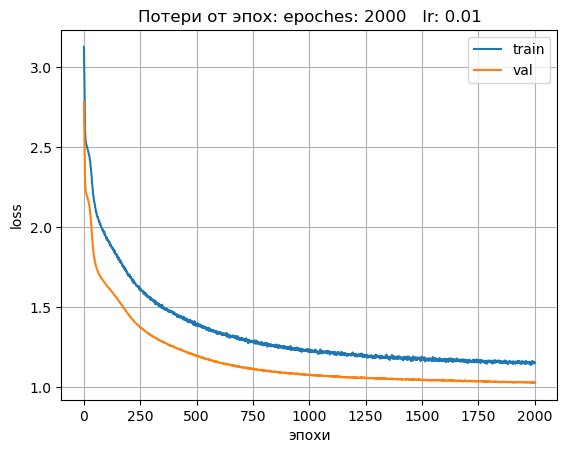

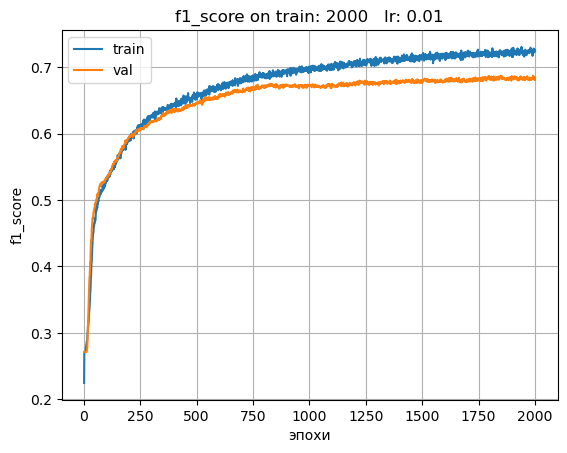

In [19]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*6),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*6, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.838, val_loss: 2.700, train f1_score: 0.171, val f1_score: 0.250
Epoch 100/2000, train loss: 1.603, val_loss: 1.545, train f1_score: 0.560, val f1_score: 0.545
Epoch 200/2000, train loss: 1.468, val_loss: 1.412, train f1_score: 0.592, val f1_score: 0.579
Epoch 300/2000, train loss: 1.397, val_loss: 1.337, train f1_score: 0.616, val f1_score: 0.591
Epoch 400/2000, train loss: 1.349, val_loss: 1.284, train f1_score: 0.642, val f1_score: 0.613
Epoch 500/2000, train loss: 1.314, val_loss: 1.244, train f1_score: 0.658, val f1_score: 0.627
Epoch 600/2000, train loss: 1.288, val_loss: 1.213, train f1_score: 0.672, val f1_score: 0.637
Epoch 700/2000, train loss: 1.268, val_loss: 1.189, train f1_score: 0.683, val f1_score: 0.647
Epoch 800/2000, train loss: 1.253, val_loss: 1.171, train f1_score: 0.691, val f1_score: 0.652
Epoch 900/2000, train loss: 1.241, val_loss: 1.157, train f1_score: 0.698, val f1_score: 0.656
Epoch 1000/2000, train loss: 1.232, val_loss: 1.147,

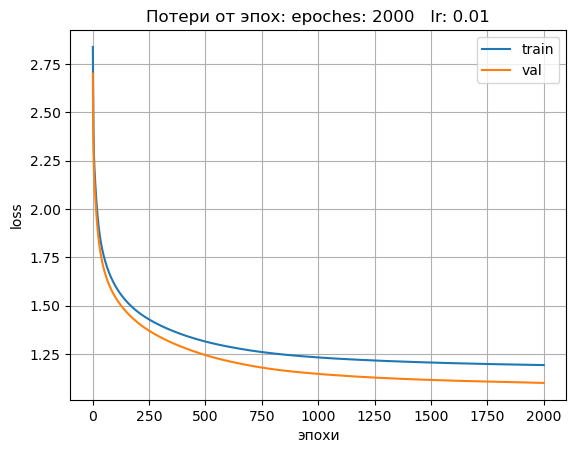

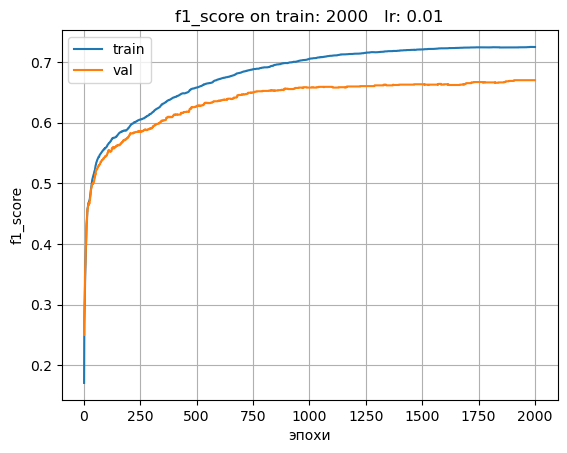

In [21]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                # nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.500, val_loss: 2.158, train f1_score: 0.322, val f1_score: 0.393
Epoch 100/2000, train loss: 1.392, val_loss: 1.322, train f1_score: 0.614, val f1_score: 0.591
Epoch 200/2000, train loss: 1.344, val_loss: 1.260, train f1_score: 0.638, val f1_score: 0.609
Epoch 300/2000, train loss: 1.310, val_loss: 1.209, train f1_score: 0.665, val f1_score: 0.632
Epoch 400/2000, train loss: 1.293, val_loss: 1.182, train f1_score: 0.678, val f1_score: 0.638
Epoch 500/2000, train loss: 1.284, val_loss: 1.167, train f1_score: 0.687, val f1_score: 0.646
Epoch 600/2000, train loss: 1.278, val_loss: 1.157, train f1_score: 0.693, val f1_score: 0.651
Epoch 700/2000, train loss: 1.274, val_loss: 1.149, train f1_score: 0.696, val f1_score: 0.652
Epoch 800/2000, train loss: 1.270, val_loss: 1.144, train f1_score: 0.699, val f1_score: 0.652
Epoch 900/2000, train loss: 1.268, val_loss: 1.139, train f1_score: 0.701, val f1_score: 0.655
Epoch 1000/2000, train loss: 1.265, val_loss: 1.135,

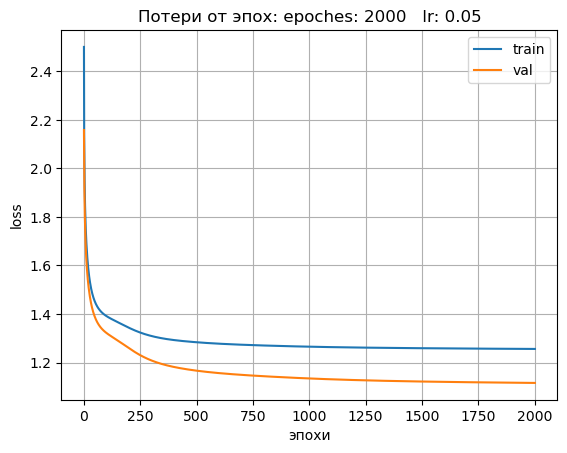

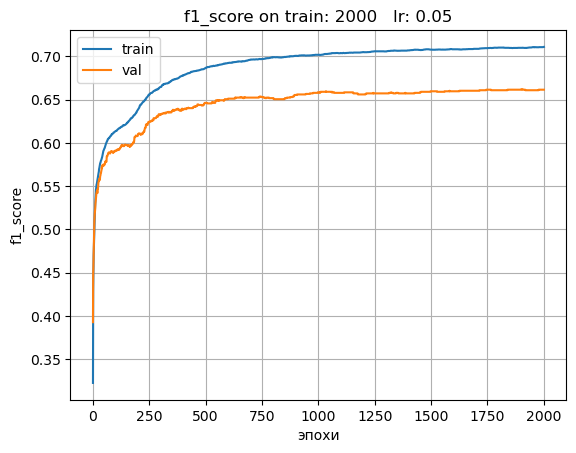

In [23]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 4),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.Tanh(),
                # nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.617, val_loss: 2.272, train f1_score: 0.271, val f1_score: 0.341
Epoch 100/2000, train loss: 1.413, val_loss: 1.277, train f1_score: 0.622, val f1_score: 0.615
Epoch 200/2000, train loss: 1.350, val_loss: 1.184, train f1_score: 0.652, val f1_score: 0.634
Epoch 300/2000, train loss: 1.326, val_loss: 1.151, train f1_score: 0.671, val f1_score: 0.644
Epoch 400/2000, train loss: 1.317, val_loss: 1.136, train f1_score: 0.672, val f1_score: 0.655
Epoch 500/2000, train loss: 1.313, val_loss: 1.127, train f1_score: 0.675, val f1_score: 0.658
Epoch 600/2000, train loss: 1.306, val_loss: 1.122, train f1_score: 0.685, val f1_score: 0.660
Epoch 700/2000, train loss: 1.299, val_loss: 1.118, train f1_score: 0.684, val f1_score: 0.662
Epoch 800/2000, train loss: 1.301, val_loss: 1.115, train f1_score: 0.686, val f1_score: 0.660
Epoch 900/2000, train loss: 1.299, val_loss: 1.113, train f1_score: 0.687, val f1_score: 0.662
________________________Ранняя остановка____________

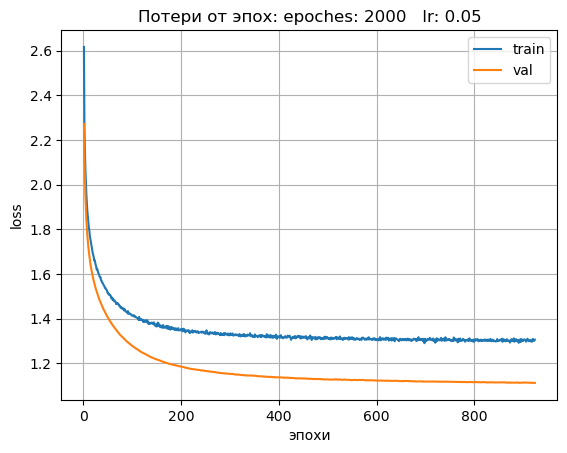

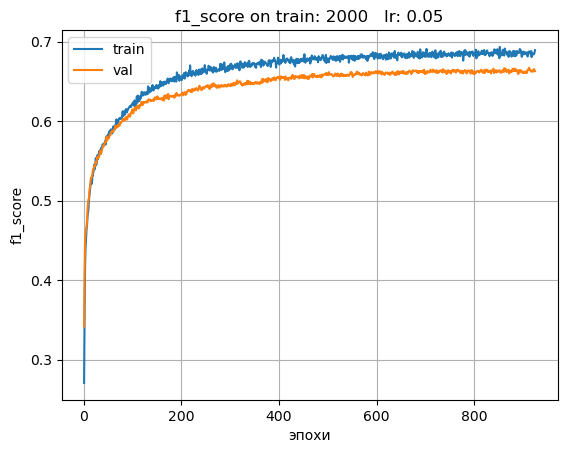

In [26]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.712, val_loss: 2.279, train f1_score: 0.263, val f1_score: 0.271
Epoch 100/2000, train loss: 1.319, val_loss: 1.146, train f1_score: 0.665, val f1_score: 0.653
Epoch 200/2000, train loss: 1.222, val_loss: 1.055, train f1_score: 0.697, val f1_score: 0.679
Epoch 300/2000, train loss: 1.187, val_loss: 1.028, train f1_score: 0.713, val f1_score: 0.679
Epoch 400/2000, train loss: 1.180, val_loss: 1.015, train f1_score: 0.717, val f1_score: 0.681
Epoch 500/2000, train loss: 1.161, val_loss: 1.005, train f1_score: 0.726, val f1_score: 0.693
Epoch 600/2000, train loss: 1.155, val_loss: 0.999, train f1_score: 0.732, val f1_score: 0.688
Epoch 700/2000, train loss: 1.153, val_loss: 0.995, train f1_score: 0.730, val f1_score: 0.691
Epoch 800/2000, train loss: 1.152, val_loss: 0.997, train f1_score: 0.729, val f1_score: 0.691
Epoch 900/2000, train loss: 1.154, val_loss: 0.995, train f1_score: 0.735, val f1_score: 0.687
Epoch 1000/2000, train loss: 1.141, val_loss: 0.992,

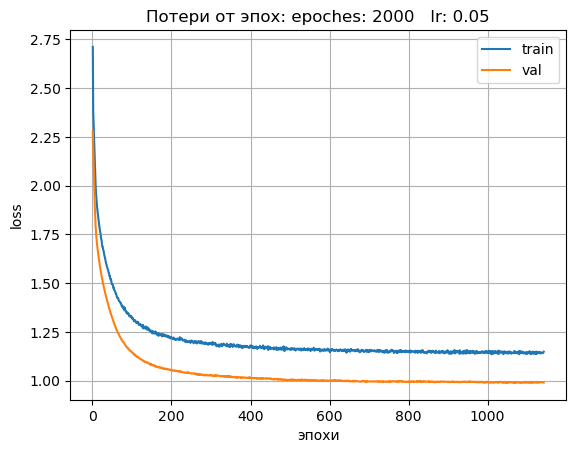

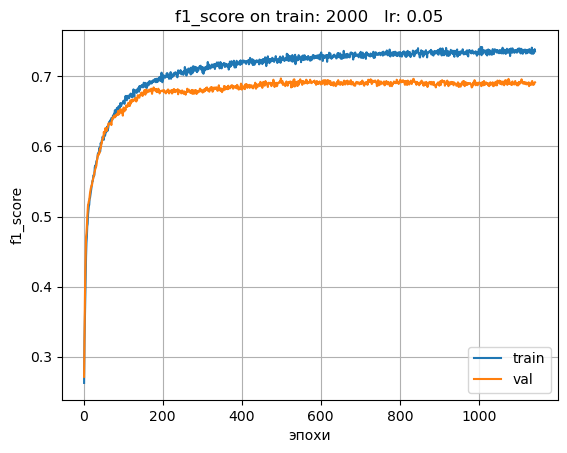

In [8]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.684, val_loss: 2.258, train f1_score: 0.250, val f1_score: 0.272
Epoch 100/2000, train loss: 1.380, val_loss: 1.184, train f1_score: 0.642, val f1_score: 0.646
Epoch 200/2000, train loss: 1.269, val_loss: 1.085, train f1_score: 0.684, val f1_score: 0.668
Epoch 300/2000, train loss: 1.237, val_loss: 1.053, train f1_score: 0.695, val f1_score: 0.676
Epoch 400/2000, train loss: 1.227, val_loss: 1.036, train f1_score: 0.699, val f1_score: 0.680
Epoch 500/2000, train loss: 1.216, val_loss: 1.026, train f1_score: 0.707, val f1_score: 0.682
Epoch 600/2000, train loss: 1.204, val_loss: 1.021, train f1_score: 0.711, val f1_score: 0.686
Epoch 700/2000, train loss: 1.210, val_loss: 1.020, train f1_score: 0.710, val f1_score: 0.684
Epoch 800/2000, train loss: 1.207, val_loss: 1.016, train f1_score: 0.715, val f1_score: 0.684
Epoch 900/2000, train loss: 1.205, val_loss: 1.010, train f1_score: 0.709, val f1_score: 0.688
Epoch 1000/2000, train loss: 1.201, val_loss: 1.007,

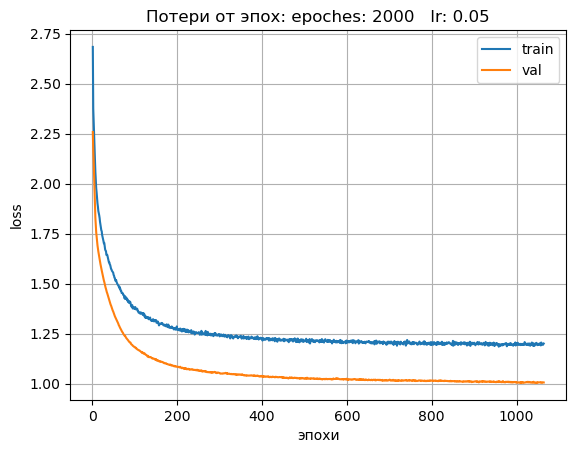

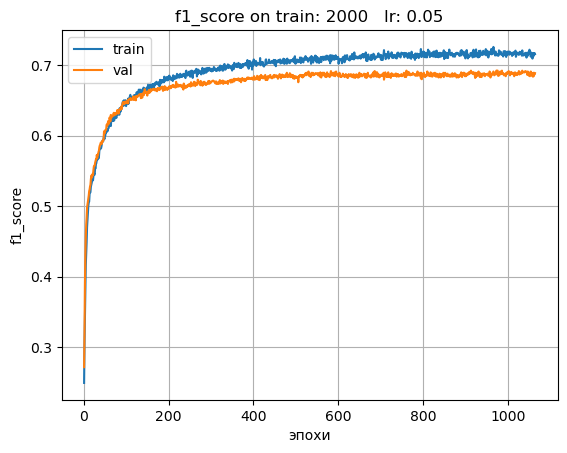

In [11]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 500,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 2.904, val_loss: 2.292, train f1_score: 0.258, val f1_score: 0.271
Epoch 100/2000, train loss: 1.417, val_loss: 1.187, train f1_score: 0.651, val f1_score: 0.657
Epoch 200/2000, train loss: 1.253, val_loss: 1.075, train f1_score: 0.689, val f1_score: 0.674
Epoch 300/2000, train loss: 1.206, val_loss: 1.050, train f1_score: 0.704, val f1_score: 0.684
Epoch 400/2000, train loss: 1.177, val_loss: 1.044, train f1_score: 0.717, val f1_score: 0.681
Epoch 500/2000, train loss: 1.162, val_loss: 1.038, train f1_score: 0.725, val f1_score: 0.684
Epoch 600/2000, train loss: 1.143, val_loss: 1.036, train f1_score: 0.732, val f1_score: 0.688
Epoch 700/2000, train loss: 1.146, val_loss: 1.024, train f1_score: 0.731, val f1_score: 0.691
Epoch 800/2000, train loss: 1.150, val_loss: 1.019, train f1_score: 0.728, val f1_score: 0.693
________________________Ранняя остановка_________________________________________________
На 840 эпохе пришлось остановить обучение
loss_840_эпохи 

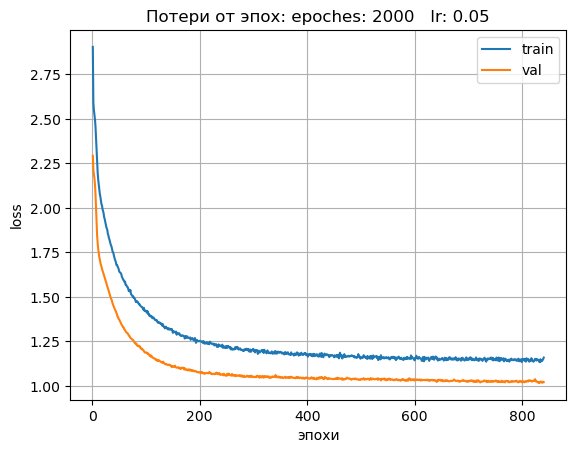

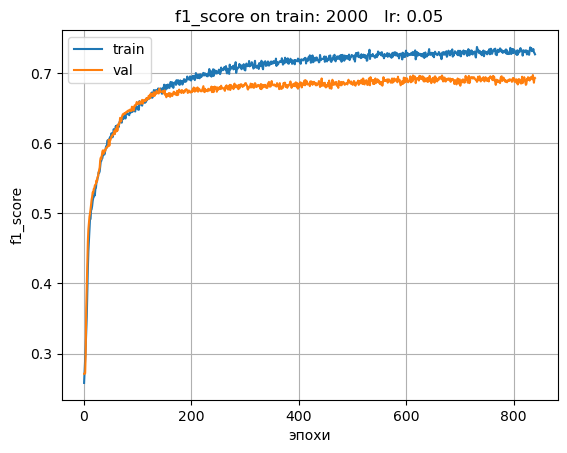

In [13]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*8),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*8, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 300,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Epoch 1/2000, train loss: 3.327, val_loss: 2.337, train f1_score: 0.259, val f1_score: 0.271
Epoch 100/2000, train loss: 1.550, val_loss: 1.265, train f1_score: 0.652, val f1_score: 0.643
Epoch 200/2000, train loss: 1.302, val_loss: 1.146, train f1_score: 0.693, val f1_score: 0.659
Epoch 300/2000, train loss: 1.204, val_loss: 1.105, train f1_score: 0.709, val f1_score: 0.670
Epoch 400/2000, train loss: 1.162, val_loss: 1.098, train f1_score: 0.721, val f1_score: 0.668
Epoch 500/2000, train loss: 1.142, val_loss: 1.089, train f1_score: 0.725, val f1_score: 0.676
Epoch 600/2000, train loss: 1.144, val_loss: 1.094, train f1_score: 0.729, val f1_score: 0.676
Epoch 700/2000, train loss: 1.146, val_loss: 1.082, train f1_score: 0.725, val f1_score: 0.673
Epoch 800/2000, train loss: 1.132, val_loss: 1.089, train f1_score: 0.733, val f1_score: 0.674
Epoch 900/2000, train loss: 1.132, val_loss: 1.094, train f1_score: 0.730, val f1_score: 0.674
________________________Ранняя остановка____________

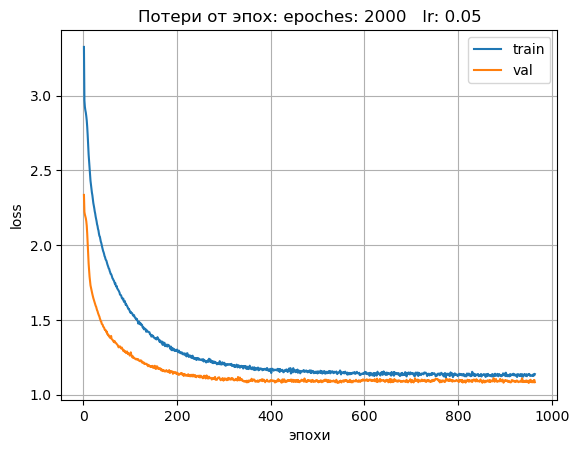

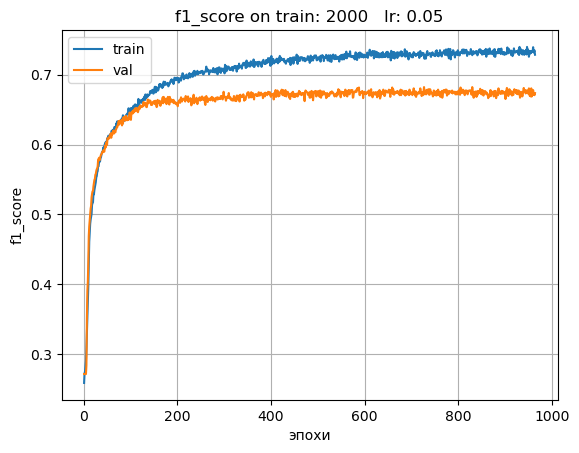

In [18]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*8),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*8, out_features = num_features*16),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*16, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 400,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

Лучшие метрики из представленных:

- train f1_score: 0.728
- val f1_score: 0.693

Epoch 1/2000, train loss: 2.920, val_loss: 2.303, train f1_score: 0.263, val f1_score: 0.271
Epoch 100/2000, train loss: 1.417, val_loss: 1.191, train f1_score: 0.653, val f1_score: 0.649
Epoch 200/2000, train loss: 1.256, val_loss: 1.086, train f1_score: 0.691, val f1_score: 0.667
Epoch 300/2000, train loss: 1.194, val_loss: 1.055, train f1_score: 0.709, val f1_score: 0.673
Epoch 400/2000, train loss: 1.175, val_loss: 1.043, train f1_score: 0.719, val f1_score: 0.677
Epoch 500/2000, train loss: 1.156, val_loss: 1.034, train f1_score: 0.724, val f1_score: 0.677
Epoch 600/2000, train loss: 1.142, val_loss: 1.031, train f1_score: 0.727, val f1_score: 0.681
Epoch 700/2000, train loss: 1.141, val_loss: 1.026, train f1_score: 0.732, val f1_score: 0.683
________________________Ранняя остановка_________________________________________________
На 733 эпохе пришлось остановить обучение
loss_733_эпохи >= loss_433_эпохи


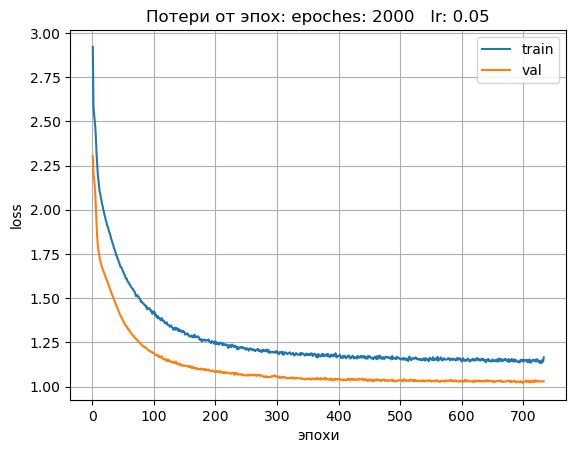

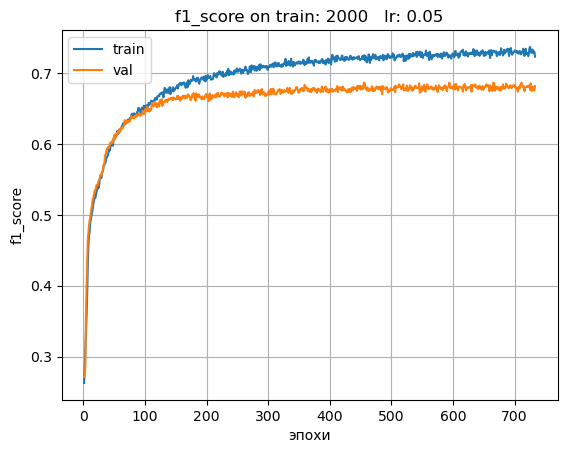

In [22]:
train_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                       mode = 'train',
                                                       unk_cutoff = 2),
                              batch_size = 128,
                              shuffle = False)

val_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                     mode = 'val',
                                                     unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)



num_features = train_dataloader.dataset[0][0].shape[0]
out_classes = len(data['nationality'].unique())

model = nn.Sequential(
                nn.Linear(in_features = num_features, out_features = num_features*2),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*2, out_features = num_features*4),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*4, out_features = num_features*8),
                nn.ReLU(),
                nn.Dropout(0.4),

                nn.Linear(in_features = num_features*8, out_features = out_classes)
    )

model = \
training_loop(
    epoches = 2000,
    model = model,
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05),
    loss_fn = nn.CrossEntropyLoss(),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 300,
    stop_diff_value = 0.001,
    verbose_epoch = 100,

    reg_type = 'l2'    
)

In [58]:
test_dataloader = DataLoader(dataset = SurnameDataset(file_path = path,
                                                      mode = 'test',
                                                      unk_cutoff = 2),
                             batch_size = 128,
                             shuffle = False)

In [63]:
f1_score_test_list = []
all_outputs_test = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
        for features, labels in test_dataloader:
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features)
                all_outputs_test = torch.concat([all_outputs_test, outputs], dim = 0)


######## Расчет метрики #####
_, predict = torch.max(torch.softmax(all_outputs_test, dim = 1), dim = 1)
y_pred = nn.functional.one_hot(predict.long(), num_classes = 18)
f1_score_to_list_test = \
f1_score(y_true = test_dataloader.dataset[:][1],
         y_pred = y_pred.cpu().detach().numpy(),
         average = 'micro')
f1_score_test_list.append(f1_score_to_list_test)
##############################

In [64]:
f1_score_test_list

[0.6795180722891566]

In [72]:
def one_hot_to_labels(one_hot_matrix):
    labels = np.argmax(one_hot_matrix, axis=1)
    return labels


y_true = one_hot_to_labels(test_dataloader.dataset[:][1])
y_pred = predict

tensor([4, 4, 0,  ..., 9, 4, 4], device='cuda:0')

In [84]:
matrix = \
confusion_matrix(y_true = y_true,
                 y_pred = y_pred.cpu())
matrix

array([[241,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,  26,   0,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   3,   0,   1,   0],
       [  0,   0,   2,   1,  30,   0,   5,   1,   0,   1,   5,   0,   0,
          0,  18,   0,   0,   0],
       [  1,   0,   3,   8,  16,   0,   4,   0,   0,   0,   1,   0,   0,
          0,   1,   0,   2,   0],
       [  4,   4,   4,   2, 379,   0,  10,   1,   0,  15,   6,   0,   0,
          0,  19,   0,   3,   0],
       [  0,   1,   0,   1,  16,   0,   1,   4,   0,   7,   1,   0,   0,
          0,   3,   0,   1,   0],
       [  0,   0,   0,   0,  44,   0,  33,   0,   0,   1,   3,   0,   0,
          0,   4,   0,   2,   0],
       [  0,   0,   1,   0,   5,   0,   0,   8,   0,   3,   3,   0,   0,
          0,   4,   0,   0,   0],
       [  0,   1,   0,   0,  17,   0,   1,   0,   3,   1,   0,   0,   0,
          0,   5,   0,   0,   0],
       [  2,   0,   0,   0,  27,   0,

In [82]:
surname_vocab = \
вернуть_словари(path = path,
                unk_cutoff = 2)[1]
surname_vocab

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

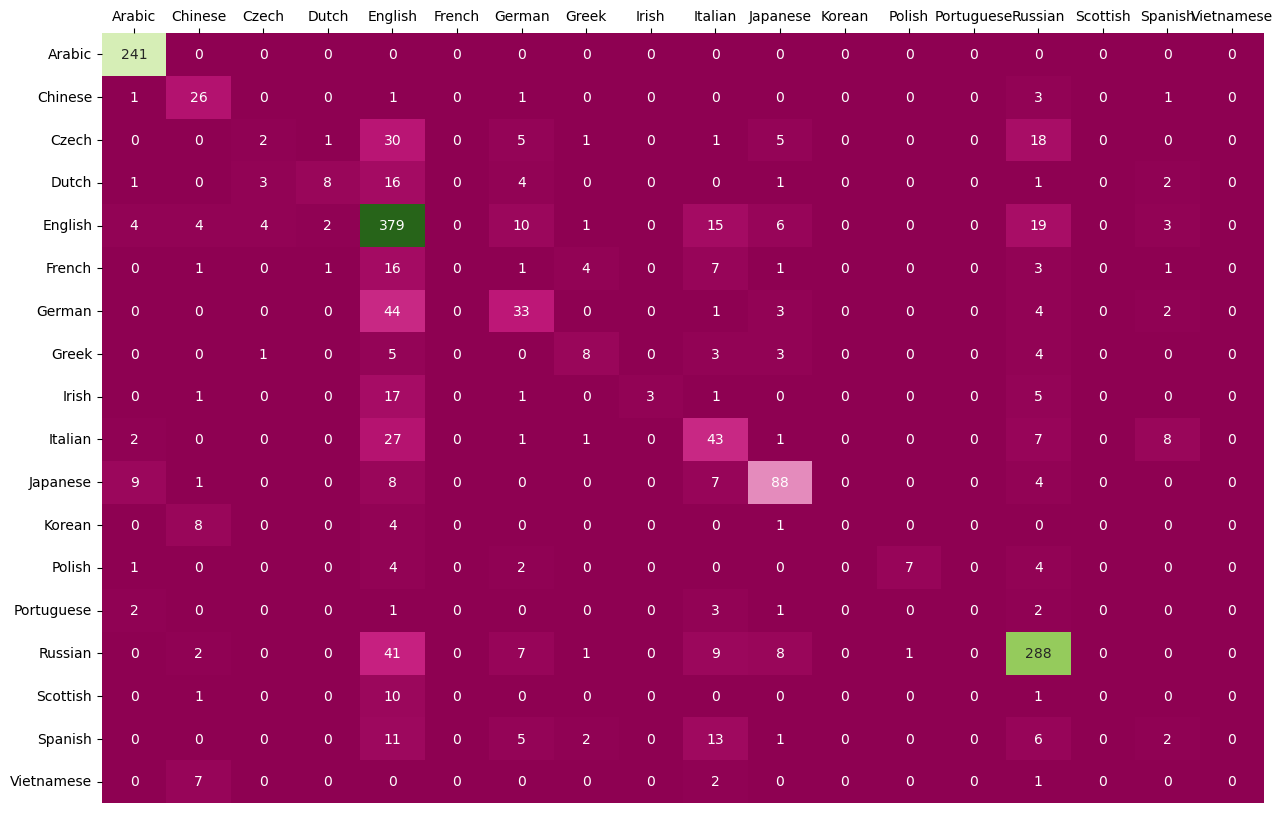

In [88]:
matrix = pd.DataFrame(matrix, columns = surname_vocab.keys(), index = surname_vocab.keys())
plt.figure(figsize = (15, 10))
ax = \
sns.heatmap(matrix,
            cmap = 'PiYG', # цветовая гамма
            cbar = False,   # отключить бар справа
            annot = True,   # показывать числа
            fmt="") # в каком виде числа: ".1f" - одно число после запятой
ax.xaxis.tick_top()

# Вывод

- метрика f1 = 0.679
- английские фамилиии выдают большинство ошибок